### Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

**When to use this workflow:** This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

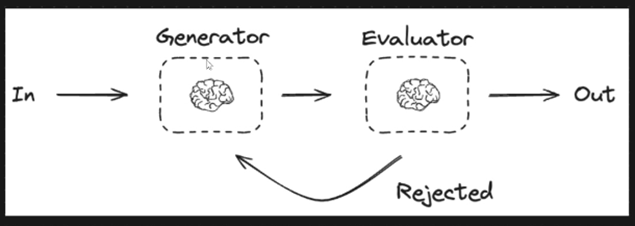
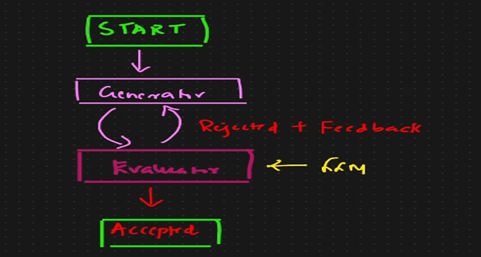

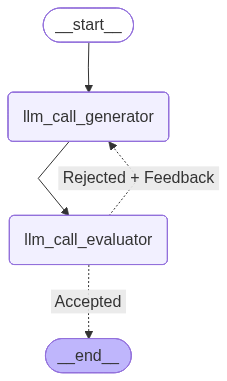

In [14]:
#🧩 Step 1: Import and Setup Environment Variables
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
# •	os and dotenv are used to load secrets like your API keys from a .env file.
# •	ChatGroq is imported to use Groq's LLM (like Qwen model).
# •	It loads your GROQ_API_KEY from the environment so you can talk to Groq's models securely.


# 🤖 Step 2: Initialize the LLM
llm = ChatGroq(model="llama-3.3-70b-versatile")
result = llm.invoke("Hello")
result
#AIMessage(content="Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_time': 0.036943225, 'prompt_time': 0.017454062, 'queue_time': 0.050819157, 'total_time': 0.054397287}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0353e259-9885-4aff-bc88-d995a21e6b46-0', usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61})

# •	You create a chatbot using the qwen-qwq-32b model from Groq.
# •	You test it by sending a simple message: "Hello".

#🧱 Step 3: Define the Graph State and Feedback Schema
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str
#•	State is a dictionary to keep track of the joke, topic, feedback, and if it's funny or not.
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )
# •	Feedback is a Pydantic model that structures how the model should respond when grading the joke.
# •	It must return:
# o	grade: "funny" or "not funny"
# o	feedback: tips for improvement

#📐 Step 4: Add Structure to the Evaluator
evaluator = llm.with_structured_output(Feedback)
#•	Now your LLM will return answers following the structure of the Feedback model.

#🔄 Step 5: Define Nodes for the Joke Workflow
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']}; but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}
#•	This function generates a joke based on the topic.
#•	If there’s feedback from a previous try, it uses that to improve the joke.
def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}
#•	This function evaluates the joke using the evaluator LLM and gives:
#o	A grade (funny or not)
#o	Feedback if it’s not funny

#🔀 Step 6: Define Routing Logic
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"
# •	This decides what to do next:
# o	If the joke is funny → end the workflow
# o	If not funny → go back and generate a new joke with the feedback

#🧠 Step 7: Build the LangGraph Workflow
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

optimizer_builder = StateGraph(State)
# •	StateGraph lets you create a graph-based workflow.
# •	You define how the state moves from one function (node) to another.
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
# •	Add both joke generator and evaluator to the graph.
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
# •	Connect the functions in order:
# 1.	Start → Generate joke
# 2.	Then → Evaluate joke
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)
# •	If joke is accepted → end
# •	If not funny → go back and generate again with feedback

#🛠️ Step 8: Compile and Visualize
optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))
# •	Compiles the graph into a runnable workflow.
# •	Displays the structure of the workflow as a diagram.

In [15]:

#🚀 Step 9: Run the Workflow
state = optimizer_workflow.invoke({"topic": "Salman Khan"})
print(state["joke"])
# •	You start the workflow with a topic: "Salman Khan".
# •	It will generate a joke, evaluate it, possibly retry, and finally print a funny joke.


Here's a revised attempt at a joke that adds a fresh twist:

Why did Salman Khan's career reach new heights after the movie 'Kick'?

Because he finally found a film where he could kick-start his acting skills, and it was a 'reel' kick in the right direction – but little did he know, his signature move would become the 'sole' reason people would be 'stepping' into the theaters to watch his films!

This revised joke still references Salman Khan's signature move and film career but adds a fresh twist with the play on words using "reel" (as in, a film reel), "sole" (as in, the sole reason, but also referencing the sole of a shoe, which ties in with the kicking motion), and "stepping" (as in, people stepping into the theaters). The goal is to create a more unexpected and clever punchline that still relates to Salman Khan's career and signature move.
